In [1]:
import numpy as np
import  matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import SGD

### Method 01 : Using scipy curve fit 

In [2]:
# let's generate some data for fitting 
dx = 0.05                       # spacing between measurements 
N = int(1.5/dx) +1              # no of data points 
x = np.linspace(-0.75,0.75,N)   # x axis data 

Text(0, 0.5, '$B_z$')

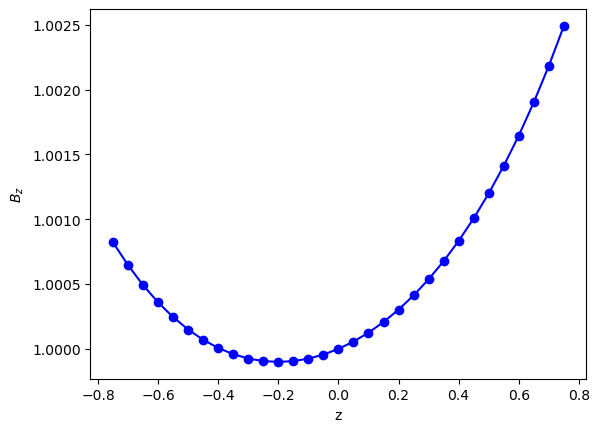

In [3]:
# generate 1D magentic field data (fake data)
cf = [1,0.001,0.0025,0.0002, 0.00079]
Bz = cf[0]  + cf[1]*x + cf[2]*x**2 + cf[3]*x**3 + cf[4]*x**4
plt.plot(x,Bz,'bo-')
plt.xlabel('z')
plt.ylabel(r'$B_z$')

In [91]:
# using sypy curve fit 

from scipy.optimize import curve_fit

# fitting a second order curve 
def func_1(x,a,b,c):
    return a*x**2 + b*x + c

# fitting a 3rd order curve 
def func_2(x,a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

# fitting 4th order curve 
def func_3(x,a,b,c,d,g):
    return a*x**4 + b*x**3 + c*x**2 + d*x + g


In [92]:
# coefficients using second order curve 
popt_1,pcov_1 = curve_fit(func_1,x,Bz,p0=(0.1,0.1,1))
order = 2
[print(f'Actual value = {cf[order-i]:4f} | predicted value = {popt_1[i]:4f} for {order-i} order coefficient ') for i in range(order+1)]

Actual value = 0.002500 | predicted value = 0.002905 for 2 order coefficient 
Actual value = 0.001000 | predicted value = 0.001072 for 1 order coefficient 
Actual value = 1.000000 | predicted value = 0.999976 for 0 order coefficient 


[None, None, None]

Text(0, 0.5, '$B_z$')

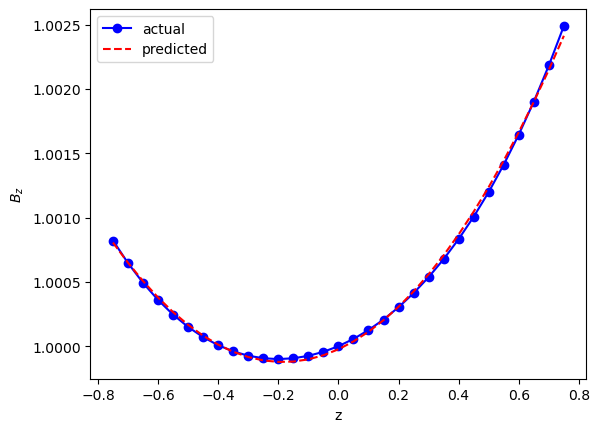

In [93]:
# plot actual vs predicted 
plt.plot(x,Bz,'bo-',label='actual')
plt.plot(x,func_1(x,*popt_1),'r--',label='predicted')
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$B_z$')

In [94]:
# coefficients using third order curve 
popt_2,pcov_2 = curve_fit(func_2,x,Bz,p0=(0.1,0.1,0.1,1))
order = 3
[print(f'Actual value = {cf[order-i]:4f} | predicted value = {popt_2[i]:4f} for {order-i} order coefficient ') for i in range(order+1)]

Actual value = 0.000200 | predicted value = 0.000200 for 3 order coefficient 
Actual value = 0.002500 | predicted value = 0.002905 for 2 order coefficient 
Actual value = 0.001000 | predicted value = 0.001000 for 1 order coefficient 
Actual value = 1.000000 | predicted value = 0.999976 for 0 order coefficient 


[None, None, None, None]

In [95]:
# coefficients of 4th order curve 
popt_3,pcov_3 = curve_fit(func_3,x,Bz,p0=(0.1,0.1,0.1,0.01,1))
order = 4
[print(f'Actual value = {cf[order-i]:4f} | predicted value = {popt_3[i]:4f} for {order-i} order coefficient ') for i in range(order+1)]

Actual value = 0.000790 | predicted value = 0.000790 for 4 order coefficient 
Actual value = 0.000200 | predicted value = 0.000200 for 3 order coefficient 
Actual value = 0.002500 | predicted value = 0.002500 for 2 order coefficient 
Actual value = 0.001000 | predicted value = 0.001000 for 1 order coefficient 
Actual value = 1.000000 | predicted value = 1.000000 for 0 order coefficient 


[None, None, None, None, None]

Text(0, 0.5, '$B_z$')

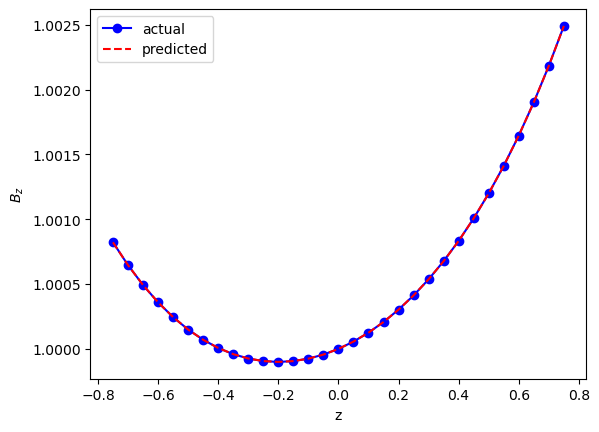

In [96]:
# plot actual vs predicted 
plt.plot(x,Bz,'bo-',label='actual')
plt.plot(x,func_3(x,*popt_3),'r--',label='predicted')
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$B_z$')

Text(0, 0.5, 'RMSE_error')

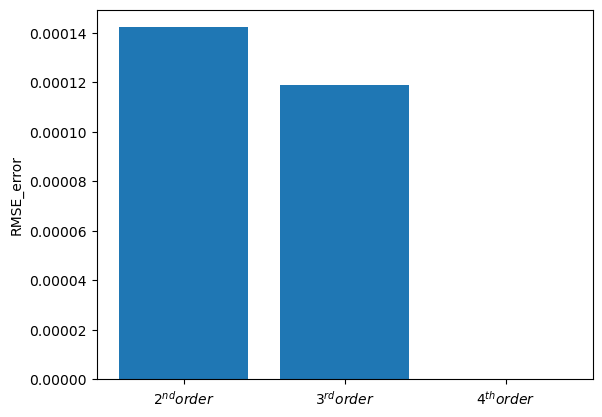

In [97]:
# how good is fitting ? 

Bz_pred_1 = func_1(x,*popt_1) 
Bz_pred_2 = func_2(x,*popt_2)
Bz_pred_3 = func_3(x,*popt_3)

def RMSE(actual,predicted):
    return np.sqrt(np.sum((actual-predicted)**2))

err_1 = RMSE(Bz,Bz_pred_1)
err_2 = RMSE(Bz,Bz_pred_2)
err_3 = RMSE(Bz,Bz_pred_3)

plt.bar([r'$2^{nd} order$',r'$3^{rd} order$',r'$4^{th} order$'],[err_1,err_2,err_3])
plt.ylabel('RMSE_error')

### Using polynomial regression 

* $f(x) = w_0 x^0 + w_1 x^1 + w_2 x^2 + w_3 x^3 + w_4 x^4 $

* As you can see, it is hard to fit a polynomial to data (**Note: in the original data the coefficients of higher order terms are small**), this is because the coefficients higher oder terms are susceptible for the noise

In [165]:
# magentic field data along line 

x = torch.linspace(-0.75,0.75,N)
Bz = cf[0]  + cf[1]*x + cf[2]*x**2 + cf[3]*x**3 + cf[4]*x**4
W = torch.tensor([0.5,0.5,0.5,0.5,0.5],dtype=torch.float32,requires_grad=True)

def get_ploy_x(x):
    X = torch.zeros(x.shape[0],5)
    for i in range(5):
        X[:,i] = torch.pow(x,i)
    return X

In [166]:
X = get_ploy_x(x)

def forward(X):
    return torch.sum(W*X,dim=1).unsqueeze(dim=1)

In [167]:
def loss(y,y_pred):
    return ((y-y_pred)**2).mean()

In [174]:
lr = 1e-3
n_iter = 100000

for epoch in range(n_iter):
    Bz_pred = forward(X)
    l = loss(Bz,Bz_pred)
    l.backward()
    with torch.no_grad():
        W -= lr*W.grad
    W.grad.zero_()
    
    if epoch % 10000 ==0:
        print(f'epoch {epoch +1}: w_0 = {W[0]:.3f} | w_1 = {W[1]:.3f} | w_2 = {W[2]:.3f} | w_3 = {W[3]:.3f} | w_4 = {W[4]:.3f} | loss={l:.8f}')
    

epoch 1: w_0 = 0.930 | w_1 = -0.087 | w_2 = 0.216 | w_3 = 0.258 | w_4 = 0.335 | loss=0.00520558
epoch 10001: w_0 = 0.971 | w_1 = -0.086 | w_2 = 0.052 | w_3 = 0.235 | w_4 = 0.246 | loss=0.00132505
epoch 20001: w_0 = 0.990 | w_1 = -0.079 | w_2 = -0.023 | w_3 = 0.215 | w_4 = 0.203 | loss=0.00046833
epoch 30001: w_0 = 0.999 | w_1 = -0.073 | w_2 = -0.057 | w_3 = 0.197 | w_4 = 0.183 | loss=0.00025862
epoch 40001: w_0 = 1.002 | w_1 = -0.067 | w_2 = -0.072 | w_3 = 0.181 | w_4 = 0.172 | loss=0.00019101
epoch 50001: w_0 = 1.004 | w_1 = -0.061 | w_2 = -0.079 | w_3 = 0.166 | w_4 = 0.167 | loss=0.00015726
epoch 60001: w_0 = 1.005 | w_1 = -0.056 | w_2 = -0.081 | w_3 = 0.152 | w_4 = 0.163 | loss=0.00013372
epoch 70001: w_0 = 1.005 | w_1 = -0.051 | w_2 = -0.082 | w_3 = 0.140 | w_4 = 0.160 | loss=0.00011493
epoch 80001: w_0 = 1.005 | w_1 = -0.047 | w_2 = -0.082 | w_3 = 0.128 | w_4 = 0.158 | loss=0.00009927
epoch 90001: w_0 = 1.005 | w_1 = -0.043 | w_2 = -0.081 | w_3 = 0.118 | w_4 = 0.156 | loss=0.00008

Text(0, 0.5, '$B_z$')

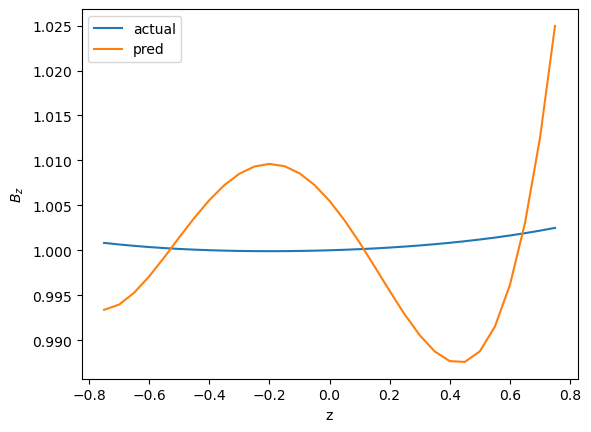

In [175]:
B_pred = forward(X)
plt.plot(x,Bz, label='actual')
plt.plot(x,Bz_pred.detach().numpy(),label='pred')
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$B_z$')

### Method 2 : Using feed forward neural network 

* first using FFNN (4 layer) without regularization  

* using L1 regularization and finally using L2 regularization 

* As you can see NN are struggling to fit data (specially when the variations are small)

### FFNN

In [98]:
# The feeed forward NN 
class LinearRegressionModel(nn.Module):
    def __init__(self,n_hidden =60):
        super().__init__()
        self.W1 = nn.Linear(1,n_hidden)
        self.W2 = nn.Linear(n_hidden,n_hidden)
        self.W3 = nn.Linear(n_hidden,n_hidden)
        self.W4 = nn.Linear(n_hidden,1)
        self.R = nn.ReLU()
        
    def forward(self,x):
        x = self.R(self.W1(x))
        #x = self.R(self.W2(x))
        #x = self.R(self.W3(x))
        x = self.W4(x)
        return x

In [99]:
# function to train the model 
def train_model(x,y,f,n_epochs=1000):
    opt = SGD(f.parameters(),lr=0.001)
    L = nn.MSELoss()
    
    # train model 
    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()
        loss_value = L(f(x),y)
        loss_value.backward()
        opt.step()
        losses.append(loss_value.item())
    return f, losses

In [100]:
# magentic field data along line 
x = torch.linspace(-0.75,0.75,N).unsqueeze(dim=1)
Bz = cf[0]  + cf[1]*x + cf[2]*x**2 + cf[3]*x**3 + cf[4]*x**4

In [101]:
# Initialize the function and train it 
f = LinearRegressionModel(n_hidden=120)
n_epochs = 5000
f,loss = train_model(x,Bz,f,n_epochs=n_epochs)

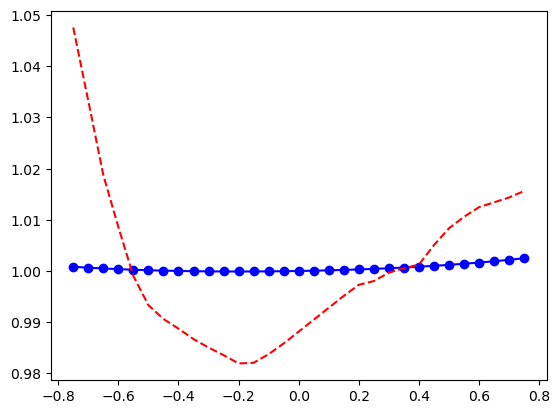

In [102]:
# compare the predicted vs actual field 
Bz_actual = Bz.detach().numpy()
Bz_predicted = f(x).detach().numpy()
x_axis = x.detach().numpy()


plt.plot(x_axis,Bz_actual,'bo-')
plt.plot(x_axis,Bz_predicted,'r--')


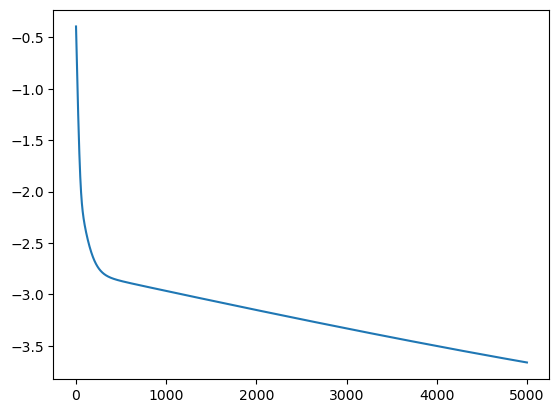

In [103]:
plt.plot(np.arange(n_epochs),np.log10(loss))

### FFNN with L1 regularization 

In [104]:
# let's try to put L1 regularization

l1_strength = 0.001

# function to train the model with L1 regularization 
def train_model(x,y,f,n_epochs=1000):
    opt = SGD(f.parameters(),lr=0.001)
    L = nn.MSELoss()
    
    # train model 
    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()
        loss_value = L(f(x),y)
        # put L1 
        l1_regularization = torch.tensor(0.)
        for param in f.parameters():
            l1_regularization += torch.norm(param,1)
        
        loss_value = loss_value + l1_strength * l1_regularization
        loss_value.backward()
        opt.step()
        losses.append(loss_value.item())
    return f, losses

In [105]:
# Initialize the function and train it 
f = LinearRegressionModel(n_hidden=120)
n_epochs = 5000
f,loss = train_model(x,Bz,f,n_epochs=n_epochs)

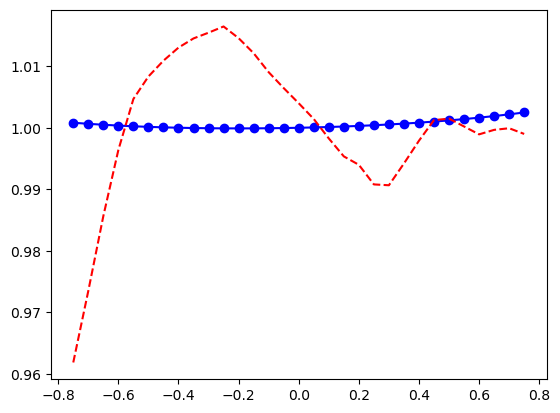

In [106]:
# compare the predicted vs actual field 
Bz_actual = Bz.detach().numpy()
Bz_predicted = f(x).detach().numpy()
x_axis = x.detach().numpy()


plt.plot(x_axis,Bz_actual,'bo-')
plt.plot(x_axis,Bz_predicted,'r--')


### FFNN with L2 regularization 

In [107]:
# let's try to put L2 regularization

l2_strength = 0.001

# function to train the model with L1 regularization 
def train_model(x,y,f,n_epochs=1000):
    opt = SGD(f.parameters(),lr=0.001)
    L = nn.MSELoss()
    
    # train model 
    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()
        loss_value = L(f(x),y)
        # put L1 
        l2_regularization = torch.tensor(0.)
        for param in f.parameters():
            l2_regularization += torch.norm(param,2)
        
        loss_value = loss_value + l2_strength * l2_regularization
        loss_value.backward()
        opt.step()
        losses.append(loss_value.item())
    return f, losses

In [108]:
# Initialize the function and train it 
f = LinearRegressionModel(n_hidden=120)
n_epochs = 5000
f,loss = train_model(x,Bz,f,n_epochs=n_epochs)

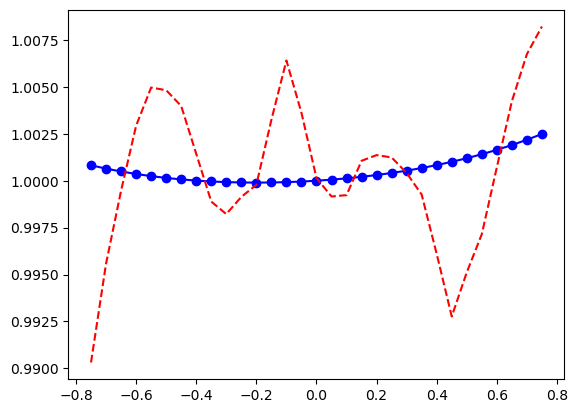

In [109]:
# compare the predicted vs actual field 
Bz_actual = Bz.detach().numpy()
Bz_predicted = f(x).detach().numpy()
x_axis = x.detach().numpy()


plt.plot(x_axis,Bz_actual,'bo-')
plt.plot(x_axis,Bz_predicted,'r--')